In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
import biosppy
import os
import padasip as pa


In [4]:
#set working directory
os.chdir("D:\Engineering\PROJECTMARS\GSR_Data")

"""Setting Up Parameters"""
df = pd.read_csv('01_A_GSR.csv')

Time = df[' TimeStamp (Shimmer)']
XShimmer = df['X (Shimmer)']
YShimmer = df['Y (Shimmer)']
ZShimmer = df['Z (Shimmer)']
SkinConductance = df['Skin Conductance']
SkinResistance = df['Skin Resistance']
PPG = df['PPG']
HRV = df['HRV']
HeartRate = df['Heart Rate']
GyroP = df['Gyro P (Shimmer)']
GyroR = df['Gyro R (Shimmer)']
GyroY = df['Gyro Y (Shimmer)']

In [5]:
def normalize(a):
    o = [None]*len(a)
    m = min(a)
    M = max(a)
    for i in range(len(a)):
        o[i]=(a[i] - m)/(M-m)
        
    return o

In [6]:
#Converting  to Numpy

ppg = PPG.to_numpy()
print(ppg)


[1466.66662598 1449.08422852 1432.96704102 ... 1500.36633301 1500.36633301
 1500.36633301]


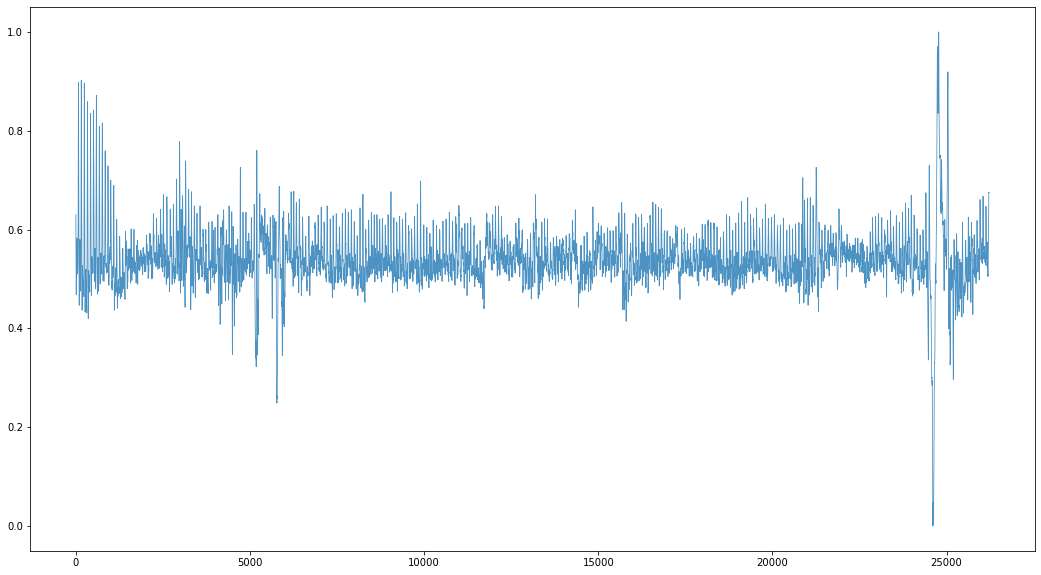

In [7]:
ppg_norm =normalize(ppg)
plt.figure(figsize=(18,10))
plt.plot(ppg_norm, lw=0.8, alpha=0.8)


In [8]:
#DC Blocker

def dc_block(ppg,a):
    x = [None]*len(ppg)
    w = [None]*len(ppg)
    y = [None]*len(ppg)
    
    for i in range(len(ppg)):
        if(i==0):
            x[0] = ppg[0]
            w[0] = x[0]
            y[0] = 0
        else:
            x[i] = ppg[i]
            w[i] = x[i] + a*w[i-1]
            y[i] = w[i]-w[i-1]
        
    return y

In [9]:

y_low_norm = dc_block(ppg_norm,0.05)
y_high_norm = dc_block(ppg_norm,0.8)
y_low = dc_block(ppg, 0.2)
y_high = dc_block(ppg,0.9)



# RLS Algorithm

s*(t) = s(t) - n(t)

n(t) = (t,k=0)SUM{w(k) * x(k)} = theta * thi

s(t) = AC_ppg

n(t) = active noise

w(k) = filter coefficients

x(k) = accelerometer data

theta = { w1, w2, w3,...,wn}

thi = { x(t-n),x(t-n+1),...,x(t)}

In [36]:
theta = []
thi = []
n = []
filt_ppg =[]
for i in range(len(XShimmer)):
    if i < 10:
        theta = np.zeros(i+1)
        thi = np.zeros(i+1)
        for x in range(i+1):
            thi[x] = XShimmer[x]
        #insert coefficient update here
    else:
        theta =np.zeros(10)
        thi = np.zeros(10)
        for x in range(10):
            thi[x] = XShimmer[i-9+x]
        #insert coefficient update here
    n = theta.dot(thi)
    filt_ppg.append(ppg[i] - n)

[1466.66662598 1449.08422852 1432.96704102 ... 1500.36633301 1500.36633301
 1500.36633301]


Formula for padasip code vs research paper conversion

y(k) = x.T(k) * w(k)  ==  n(t) = theta.T * thi

w(k+1) = w(k) + Δw(k)  ==  theta(t) = theta(t-1) + b * (s(t) - n(t))

Δw(k) = R(k) * x(k) * e(k) == ??

??                         ==  b = (P(t-1) * thi(t))/(1 + thi(t) * P(t-1) * thi.T(t))

R(k) = (1/mu) * (R(k-1) - (R(k-1) * x(k) * x.T(K) * R(k-1))/ (mu + x.T(k) * R(k-1) * x(k))) ==

P(t) = (P(t-1) - (P(t-1) * thi(t) * thi.T(t) * P(t-1))/ (1 + thi(t) * P(t-1) * thi.T(t)))

e(k) = error
R(0) = identity matrix

In [37]:
f = pa.filters.FilterRLS(n=10, mu=1, w="zeros")